In [1]:
import open3d as o3d
import numpy as np
import copy
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/vertex_map.npy already exists, skipped.


# ICP registration
This tutorial demonstrates the ICP (Iterative Closest Point) registration algorithm. It has been a mainstay of geometric registration in both research and industry for many years. The input are two point clouds and an initial transformation that roughly aligns the source point cloud to the target point cloud. The output is a refined transformation that tightly aligns the two point clouds. A helper function `draw_registration_result` visualizes the alignment during the registration process. In this tutorial, we show two ICP variants, the point-to-point ICP and the point-to-plane ICP [\[Rusinkiewicz2001\]](../reference.html#rusinkiewicz2001).

## Helper visualization function
The function below visualizes a target point cloud and a source point cloud transformed with an alignment transformation. The target point cloud and the source point cloud are painted with cyan and yellow colors respectively. The more and tighter the two point clouds overlap with each other, the better the alignment result.

In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

<div class="alert alert-info">
    
**Note:** 

Since the functions `transform` and `paint_uniform_color` change the point cloud, we call `copy.deepcopy` to make copies and protect the original point clouds.

</div>

## Input
The code below reads a source point cloud and a target point cloud from two files. A rough transformation is given.

<div class="alert alert-info">
    
**Note:** 

The initial alignment is usually obtained by a global registration algorithm. See [Global registration](../pipelines/global_registration.rst) for examples.

</div>

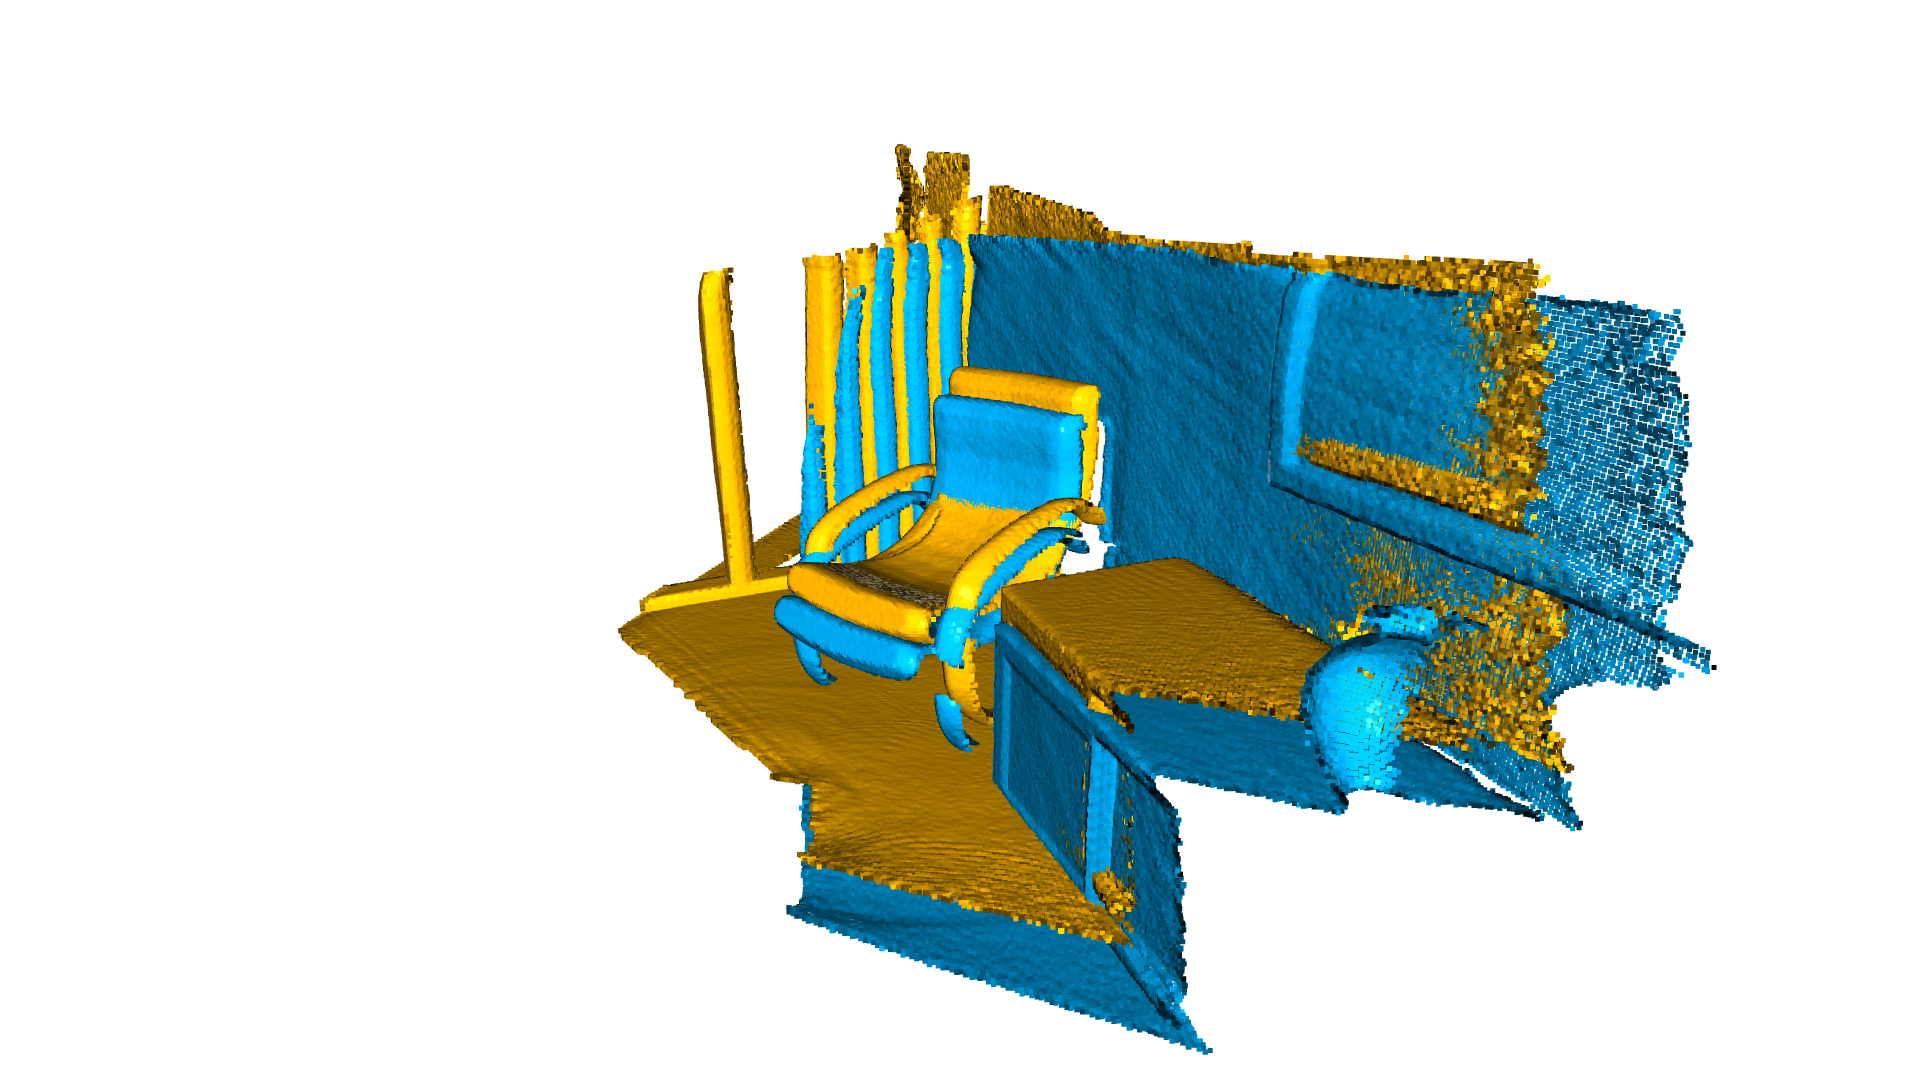

In [3]:
source = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
target = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

The function `evaluate_registration` calculates two main metrics:

- `fitness`, which measures the overlapping area (# of inlier correspondences / # of points in target). The higher the better.
- `inlier_rmse`, which measures the RMSE of all inlier correspondences. The lower the better.

In [ ]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

## Point-to-point ICP
In general, the ICP algorithm iterates over two steps:

1. Find correspondence set $\mathcal{K}=\{(\mathbf{p}, \mathbf{q})\}$ from target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$ transformed with current transformation matrix $\mathbf{T}$.
2. Update the transformation $\mathbf{T}$ by minimizing an objective function $E(\mathbf{T})$ defined over the correspondence set $\mathcal{K}$.

Different variants of ICP use different objective functions $E(\mathbf{T})$ [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) [\[Park2017\]](../reference.html#park2017).

We first show a point-to-point ICP algorithm [\[BeslAndMcKay1992\]](../reference.html#beslandmckay1992) using the objective

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\|\mathbf{p} - \mathbf{T}\mathbf{q}\|^{2}
\end{equation}

The class `TransformationEstimationPointToPoint` provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective. The function `registration_icp` takes it as a parameter and runs point-to-point ICP to obtain the results.

In [ ]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

The `fitness` score increases from 0.174723 to 0.372450. The `inlier_rmse` reduces from 0.011771 to 0.007760. By default, `registration_icp` runs until convergence or reaches a maximum number of iterations (30 by default). It can be changed to allow more computation time and to improve the results further.

In [ ]:
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

The final alignment is tight. The `fitness` score improves to 0.621123. The `inlier_rmse` reduces to 0.006583.

## Point-to-plane ICP
The point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) uses a different objective function

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$. [\[Rusinkiewicz2001\]](../reference.html#rusinkiewicz2001) has shown that the point-to-plane ICP algorithm has a faster convergence speed than the point-to-point ICP algorithm.

`registration_icp` is called with a different parameter `TransformationEstimationPointToPlane`. Internally, this class implements functions to compute the residuals and Jacobian matrices of the point-to-plane ICP objective.

In [ ]:
print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

The point-to-plane ICP reaches tight alignment within 30 iterations (a `fitness` score of 0.620972 and an `inlier_rmse` score of 0.006581).

<div class="alert alert-info">
    
The point-to-plane ICP algorithm uses point normals. In this tutorial, we load normals from files. If normals are not given, they can be computed with [Vertex normal estimation](pointcloud.ipynb#vertex-normal-estimation).

</div>